In [1]:
import requests, wikipedia, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from everypolitician import EveryPolitician
%matplotlib inline

In [184]:
loud = True
session = 114

In [4]:
bills = [ ]
reps  = [ ]
dist  = [ ]
for bill_id in range(1,6750):
    if bill_id % 250 == 0 and loud:
        print('--> pulling HR%s' % bill_id)
    
    url = 'https://www.govtrack.us/data/congress/%s/bills/hr/hr%d/data.json' % (session, bill_id)
    res = requests.get(url)
    
    if res.status_code != 200:
        continue
    
    data = res.json()   
    
    bill = {
        '_type': 'hr',
        '_id': bill_id,
        '_status': data['status'],
        '_sponsor': data['sponsor']['name'],
        '_subject': data['subjects_top_term']
    }
    
    # mark bill's (co)sponsors accordingly
    bill[data['sponsor']['name']] = 0
    for cosponsor in data['cosponsors']:
        bill[cosponsor['name']] = 1 if cosponsor['original_cosponsor'] else 2
        
    bills.append(bill)
    
    # add bill's (co)sponsors to list (if not already)
    sponsor_dist = "%s%s" % (data['sponsor']['state'], data['sponsor']['district'])
    if sponsor_dist not in dist:
        reps.append(data['sponsor'])
        dist.append(sponsor_dist)
            
    for cosponsor in data['cosponsors']:
        cosponsor_dist = "%s%s" % (cosponsor['state'], cosponsor['district'])
        if cosponsor_dist not in dist:
            reps.append(cosponsor)
            dist.append(cosponsor_dist)

print("done")

--> pulling HR250
--> pulling HR500
--> pulling HR750
--> pulling HR1000
--> pulling HR1250
--> pulling HR1500
--> pulling HR1750
--> pulling HR2000
--> pulling HR2250
--> pulling HR2500
--> pulling HR2750
--> pulling HR3000
--> pulling HR3250
--> pulling HR3500
--> pulling HR3750
--> pulling HR4000
--> pulling HR4250
--> pulling HR4500
--> pulling HR4750
--> pulling HR5000
--> pulling HR5250
--> pulling HR5500
--> pulling HR5750
--> pulling HR6000
--> pulling HR6250
--> pulling HR6500
done


### Build the Bills and Representative Dataframe

In [185]:
bills_df = pd.DataFrame(bills)
bills_df['_subject'].fillna('None', inplace=True)
# bills_df.fillna('-', inplace=True)

print("total bills: %d" % bills_df.shape[0])
bills_df.head()

total bills: 6526


,"Abraham, Ralph Lee","Adams, Alma S.","Aderholt, Robert B.","Aguilar, Pete","Allen, Rick W.","Amash, Justin","Amodei, Mark E.","Ashford, Brad","Babin, Brian","Barletta, Lou",...,"Young, David","Young, Don","Young, Todd C.","Zeldin, Lee M.","Zinke, Ryan K.",_id,_sponsor,_status,_subject,_type
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2,"Burgess, Michael C.",ENACTED:SIGNED,Health,hr
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,...,NaN,NaN,NaN,NaN,1.0,3,"Cramer, Kevin",PASS_OVER:HOUSE,Energy,hr
2,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5,"Kline, John",PASS_OVER:HOUSE,Education,hr
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0,NaN,2.0,...,2.0,NaN,NaN,2.0,2.0,6,"Upton, Fred",PASS_OVER:HOUSE,Health,hr
4,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,7,"Smith, Christopher H.",PASS_OVER:HOUSE,"Civil rights and liberties, minority issues",hr


In [186]:
reps_df = pd.DataFrame([{'district': r['district'], 'name': r['name'], 'state': r['state']} for r in reps])

print("total reps: %d" % reps_df.shape[0])
reps_df.head()

total reps: 441


,district,name,state
0,26,"Burgess, Michael C.",TX
1,3,"Boustany, Charles W., Jr.",LA
2,8,"Brady, Kevin",TX
3,2,"Courtney, Joe",CT
4,29,"Green, Gene",TX


## Save our data

In [187]:
# save bills and reps in CSV (faster)
bills_df.to_csv('data/bills-%s.csv' % session)
reps_df.to_csv('data/reps-%s.csv' % session)

# save bills and reps in XLS (slower but little easier to use)
writer = pd.ExcelWriter('data/data-%s.xlsx' % session)
bills_df.to_excel(writer, 'bills')
reps_df.to_excel(writer, 'reps')
writer.save()

#### Load our previously saved data

In [188]:
bills_df = pd.read_csv('data/bills-%s.csv' % session, index_col = 0)
reps_df  = pd.read_csv('data/reps-%s.csv'  % session, index_col = 0)

### Clean up `bills_df` (and a little bit of exploration)

In [189]:
pass_statuses = ["ENACTED:SIGNED", "PASS_OVER:HOUSE", "PROV_KILL:CLOTUREFAILED", \
                 "PASS_BACK:SENATE", "PROV_KILL:VETO", "CONFERENCE:PASSED:HOUSE", \
                 "VETOED:OVERRIDE_FAIL_ORIGINATING:HOUSE", "ENACTED:TENDAYRULE"]

bills_df['_passed'] = np.vectorize(lambda x: x in pass_statuses)(bills_df['_status'])

In [308]:
bills_subject_df = pd.DataFrame(bills_df['_subject'].value_counts(normalize = True))

bills_subject_df['passed'] = bills_df[bills_df['_passed'] == True]\
                                     ['_subject'].value_counts(normalize = True)

bills_subject_df.columns = ['all', 'passed']
bills_subject_df.fillna(0, inplace = True)
bills_subject_df['diff'] = bills_subject_df['passed'] - \
                           bills_subject_df['all']
    
bills_subject_df.sort_values('diff', ascending = False, inplace = True)
bills_subject_df

,all,passed,diff
Government operations and politics,0.070028,0.166882,0.096855
Emergency management,0.015783,0.053040,0.037257
Finance and financial sector,0.048115,0.081501,0.033385
Armed forces and national security,0.090867,0.112549,0.021681
Public lands and natural resources,0.051640,0.072445,0.020805
"Science, technology, communications",0.019614,0.040103,0.020490
International affairs,0.037849,0.050453,0.012604
Energy,0.024517,0.033635,0.009118
Native Americans,0.011952,0.020699,0.008746
Law,0.009347,0.015524,0.006177


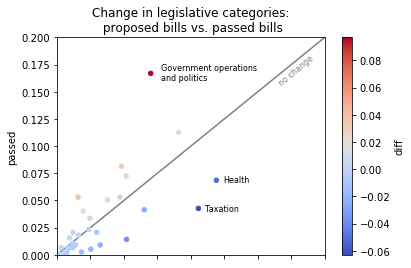

In [309]:
ax = bills_subject_df.plot.scatter('all', 'passed', c = 'diff', cmap=plt.cm.coolwarm)
ax.plot([0, 0.2], [0, 0.2], 'k-', alpha=0.5, zorder=0)
ax.set_xlim([0, 0.2])
ax.set_ylim([0, 0.2])
ax.set_title('Change in legislative categories:\n proposed bills vs. passed bills')
plt.figtext(.635,.80,'no change', fontsize=8, color='grey', rotation='40')
plt.figtext(.365,.73,'Government operations\nand politics', fontsize=8)
plt.figtext(.51,.378,'Health', fontsize=8)
plt.figtext(.465,.275,'Taxation', fontsize=8)

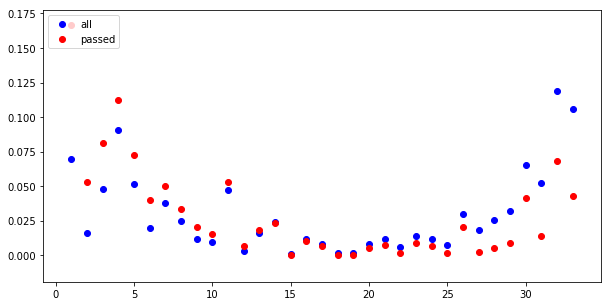

In [315]:
bills_subject_df['x_ix'] = range(bills_subject_df.shape[0])
bills_subject_df['x_ix'] = bills_subject_df['x_ix'] + 1

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(111)

ax1.scatter(bills_subject_df['x_ix'], bills_subject_df['all'], c='b', label='all')
ax1.scatter(bills_subject_df['x_ix'], bills_subject_df['passed'], c='r', label='passed')
plt.legend(loc='upper left');
plt.show()

## Clean up and extend `reps_df`

In [171]:
def clean_rep_name(name):
    name_array = list(map(str.strip, name.split(',')))
    name_array[0], name_array[1] = name_array[1], name_array[0] 
    return ' '.join(name_array)

reps_df['full name'] = np.vectorize(clean_rep_name)(reps_df['name'])
reps_df['full district'] = np.vectorize(lambda x, y: "%s-%s" % (x, y))(reps_df['state'], reps_df['district'])

### Get each representitive's political party using [EveryPolitician API](http://everypolitician.org/)

In [172]:
ep = EveryPolitician()
usa = ep.country('United-States-of-America')
cong114 = usa.legislature('House').legislative_periods()[1].csv()

def find_rep_party(name):
    first_name = name.split(' ')[0]
    last_name  = name.split(' ')[-1]
    matches    = [row['group'] for row in cong114 if first_name in row["name"] and last_name in row["name"]]
    return ''.join(matches)

reps_df['party'] = np.vectorize(find_rep_party)(reps_df['full name'])

#### Manually clean up any missed matches

In [173]:
reps_df[(reps_df['party'] != "Democrat") & (reps_df['party'] != "Republican")]

,district,name,state,full name,full district,party
73,29,"Cardenas, Tony",CA,Tony Cardenas,CA-29,
118,4,"Gutierrez, Luis V.",IL,Luis V. Gutierrez,IL-4,
128,15,"Hinojosa, Ruben",TX,Ruben Hinojosa,TX-15,
169,3,"Lujan, Ben Ray",NM,Ben Ray Lujan,NM-3,
189,16,"O'Rourke, Beto",TX,Beto O'Rourke,TX-16,
192,10,"Payne, Donald M., Jr.",NJ,Donald M. Payne Jr.,NJ-10,DemocratDemocrat
238,7,"Velazquez, Nydia M.",NY,Nydia M. Velazquez,NY-7,
261,2,"Duncan, John J., Jr.",TN,John J. Duncan Jr.,TN-2,DemocratDemocratDemocratRepublican
296,8,"Beyer, Donald S., Jr.",VA,Donald S. Beyer Jr.,VA-8,DemocratDemocrat
299,0,"Carney, John C., Jr.",DE,John C. Carney Jr.,DE-0,DemocratDemocratDemocratRepublican


In [174]:
reps_df.loc[reps_df['full name'] == "Walter B. Jones Jr.", "party"] = "Republican"
reps_df.loc[reps_df['full name'] == "Raul R. Labrador", "party"]    = "Republican"
reps_df.loc[reps_df['full name'] == "John J. Duncan Jr.", "party"]  = "Republican"

# turns out the rest are Democrats
reps_df.loc[(reps_df['party'] != "Democrat") & (reps_df['party'] != "Republican") & \
            (reps_df['party'] != "Independent"), 'party'] = "Democrat"

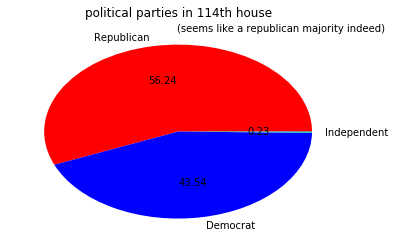

In [175]:
plt.plot()
reps_df['party'].value_counts().plot.pie(colors=['r', 'b', 'c'], autopct='%.2f')
plt.title('political parties in 114th house')
plt.figtext(.75,.85,'(seems like a republican majority indeed)', fontsize=10, ha='center')
plt.ylabel('')

## Calculate success rates for each representitive 

In [176]:
# get counts for sponsorships
reps_df['sponsorships'] = np.vectorize(lambda x: bills_df[bills_df[x] == 0].shape[0])(reps_df['name'])
reps_df['passed sponsorships'] = np.vectorize(lambda x: bills_df[(bills_df[x] == 0) & \
                                                                 (bills_df['_passed'] == True)].shape[0])\
                                                                 (reps_df['name'])
reps_df['sponsor success rate'] = reps_df['passed sponsorships'] / reps_df['sponsorships']

# get counts for original cosponsorships
reps_df['original cosponsorships'] = np.vectorize(lambda x: bills_df[bills_df[x] == 1].shape[0])(reps_df['name'])
reps_df['passed original cosponsorships'] = np.vectorize(lambda x: bills_df[(bills_df[x] == 1) & \
                                                                            (bills_df['_passed'] == True)].shape[0])\
                                                                            (reps_df['name'])
reps_df['original cosponsor success rate'] = reps_df['passed original cosponsorships'] / \
                                             reps_df['original cosponsorships']

# get counts for other cosponsorships (non-original)
reps_df['other cosponsorships'] = np.vectorize(lambda x: bills_df[bills_df[x] == 2].shape[0])(reps_df['name'])
reps_df['passed other cosponsorships'] = np.vectorize(lambda x: bills_df[(bills_df[x] == 2) & \
                                                                         (bills_df['_passed'] == True)].shape[0])\
                                                                         (reps_df['name'])
reps_df['other cosponsor success rate'] = reps_df['passed other cosponsorships'] / reps_df['other cosponsorships']

# get count of total bills for rep
reps_df['total bills'] = reps_df['sponsorships'] + reps_df['original cosponsorships'] + \
                                                   reps_df['other cosponsorships']

In [177]:
reps_df.head()

,district,name,state,full name,full district,party,sponsorships,passed sponsorships,sponsor success rate,original cosponsorships,passed original cosponsorships,original cosponsor success rate,other cosponsorships,passed other cosponsorships,other cosponsor success rate,total bills
0,26,"Burgess, Michael C.",TX,Michael C. Burgess,TX-26,Republican,37,4,0.108108,79,15,0.189873,145,34,0.234483,261
1,3,"Boustany, Charles W., Jr.",LA,Charles W. Boustany Jr.,LA-3,Republican,37,1,0.027027,105,17,0.161905,211,43,0.203791,353
2,8,"Brady, Kevin",TX,Kevin Brady,TX-8,Republican,23,7,0.304348,42,14,0.333333,63,20,0.317460,128
3,2,"Courtney, Joe",CT,Joe Courtney,CT-2,Democrat,7,0,0.000000,69,7,0.101449,181,32,0.176796,257
4,29,"Green, Gene",TX,Gene Green,TX-29,Democrat,13,0,0.000000,97,15,0.154639,125,20,0.160000,235


In [178]:
reps_df.fillna(0, inplace = True)
reps_df['weighted average'] = (3 * reps_df['sponsor success rate'] + 2 * reps_df['original cosponsor success rate'] \
                                 + reps_df['other cosponsor success rate']) / 6

In [179]:
# reorder columns and sort
reps_df = reps_df[['full name', 'full district', 'party', 'weighted average', 'total bills', 'sponsorships', \
                   'passed sponsorships', 'sponsor success rate', 'original cosponsorships', \
                   'passed original cosponsorships', 'original cosponsor success rate', 'other cosponsorships', \
                   'passed other cosponsorships', 'other cosponsor success rate', 'district', 'name', 'state']]
reps_df.sort_values(['weighted average', 'sponsorships', 'original cosponsorships', 'other cosponsorships'], \
                    ascending = False).head()

,full name,full district,party,weighted average,total bills,sponsorships,passed sponsorships,sponsor success rate,original cosponsorships,passed original cosponsorships,original cosponsor success rate,other cosponsorships,passed other cosponsorships,other cosponsor success rate,district,name,state
267,Kevin McCarthy,CA-23,Republican,0.766667,21,9,6,0.666667,10,8,0.800000,2,2,1.000000,23,"McCarthy, Kevin",CA
58,Mike Bishop,MI-8,Republican,0.635198,244,2,2,1.000000,42,10,0.238095,200,67,0.335000,8,"Bishop, Mike",MI
410,Barry Loudermilk,GA-11,Republican,0.602198,174,6,5,0.833333,66,28,0.424242,102,27,0.264706,11,"Loudermilk, Barry",GA
408,Trent Kelly,MS-1,Republican,0.593202,94,2,2,1.000000,16,3,0.187500,76,14,0.184211,1,"Kelly, Trent",MS
260,John A. Boehner,OH-8,Republican,0.583333,3,2,1,0.500000,1,1,1.000000,0,0,0.000000,8,"Boehner, John A.",OH


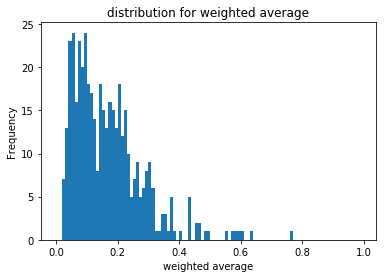

In [180]:
plt.plot()
reps_df['weighted average'].plot.hist(bins = np.arange(0.0, 1.0, 0.01))
plt.title('distribution for weighted average')
plt.xlabel('weighted average')

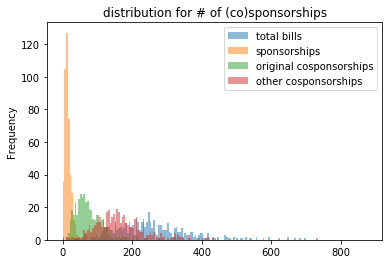

In [181]:
reps_df[['total bills','sponsorships', 'original cosponsorships', 'other cosponsorships']].plot.hist(
    alpha = 0.5, bins = np.arange(0, np.max(reps_df['total bills']), 5))
plt.title('distribution for # of (co)sponsorships')

In [182]:
print('representitives with 0 sponsorships: %d' % reps_df[reps_df['sponsorships'] == 0].shape[0])
print('representitives with 0 original cosponsorships: %d' % reps_df[reps_df['original cosponsorships'] == 0].shape[0])
print('representitives with 0 other cosponsorships: %d' % reps_df[reps_df['other cosponsorships'] == 0].shape[0])

max_sponsor = reps_df.iloc[reps_df['sponsorships'].argmax()]
print('representitive w/ max sponsorships: %s (%s), %d' % (max_sponsor['full name'], \
                                                           max_sponsor['party'][0], \
                                                           max_sponsor['sponsorships']))

max_cosponsor = reps_df.iloc[reps_df['original cosponsorships'].argmax()]
print('representitive w/ max original sponsorships: %s (%s), %d' % (max_cosponsor['full name'], \
                                                                    max_cosponsor['party'][0], \
                                                                    max_cosponsor['sponsorships']))

representitives with 0 sponsorships: 0
representitives with 0 original cosponsorships: 0
representitives with 0 other cosponsorships: 1
representitive w/ max sponsorships: Alan Grayson (D), 103
representitive w/ max original sponsorships: Eleanor Holmes Norton (D), 48


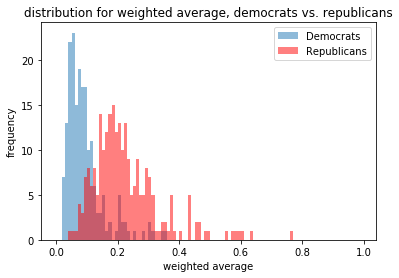

In [183]:
bins = np.arange(0, 1, 0.01)
plt.hist(reps_df[reps_df['party'] == "Democrat"]['weighted average'], bins, alpha=0.5, label='Democrats')
plt.hist(reps_df[reps_df['party'] == "Republican"]['weighted average'], bins, color = 'r', alpha=0.5, label='Republicans')
plt.title('distribution for weighted average, democrats vs. republicans')
plt.xlabel('weighted average')
plt.ylabel('frequency')
plt.legend(loc='upper right')
plt.show()